# Toronto neighborhoods project

The project involves scapping data on Toronto from the webpage, cleaning it, linking to geographical coordinates to map, obtainin data on venues from Foursquare api, and clustering neighbourhoods. 

# Part I

Importing all the necessary packages:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from urllib.request import urlopen
from bs4 import BeautifulSoup as bsoup
import requests
import lxml
from urllib.request import urlopen as uReq

import json
from geopy.geocoders import Nominatim
import requests
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
!conda install -c conda-forge folium=0.5.0 --yes
import folium
print('done')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    folium-0.5.0               |             py_0          45 KB  conda-forge
    openssl-1.1.1d             |       h516909a_0         2.1 MB  conda-forge
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    altair-4.0.1               |             py_0         575 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    branca-0.4.0               |             py_0          26 KB  conda-forge
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.0 MB

The following NEW packages will be 

Since the data comes from a webpage, we need utilize a library for scaping data, in this case using Beautiful Soup

In [2]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
html = urlopen(url)
r=requests.get(url)
webpage = bsoup(r.text, 'html.parser')
print('done')


done


In [3]:
workingtable = webpage.table
workingtable

<table class="wikitable sortable">
<tbody><tr>
<th>Postcode</th>
<th>Borough</th>
<th>Neighbourhood
</th></tr>
<tr>
<td>M1A</td>
<td>Not assigned</td>
<td>Not assigned
</td></tr>
<tr>
<td>M2A</td>
<td>Not assigned</td>
<td>Not assigned
</td></tr>
<tr>
<td>M3A</td>
<td><a href="/wiki/North_York" title="North York">North York</a></td>
<td><a href="/wiki/Parkwoods" title="Parkwoods">Parkwoods</a>
</td></tr>
<tr>
<td>M4A</td>
<td><a href="/wiki/North_York" title="North York">North York</a></td>
<td><a href="/wiki/Victoria_Village" title="Victoria Village">Victoria Village</a>
</td></tr>
<tr>
<td>M5A</td>
<td><a href="/wiki/Downtown_Toronto" title="Downtown Toronto">Downtown Toronto</a></td>
<td><a href="/wiki/Regent_Park" title="Regent Park">Harbourfront</a>
</td></tr>
<tr>
<td>M6A</td>
<td><a href="/wiki/North_York" title="North York">North York</a></td>
<td><a href="/wiki/Lawrence_Heights" title="Lawrence Heights">Lawrence Heights</a>
</td></tr>
<tr>
<td>M6A</td>
<td><a href="/wiki/North

However, now the table needs to be cleaned up and be workable with. 

In [4]:
output = workingtable.find_all('tr')
rows = len(output)
rows

288

In [5]:
header = output[0].text.split()
header

['Postcode', 'Borough', 'Neighbourhood']

In [6]:
rawoutput = []
n=1
while n<rows:
    Postcode = output[n].text.split('\n')[1]
    Borough = output[n].text.split('\n')[2]
    Neighborhood = output[n].text.split('\n')[3]
    rawoutput.append((Postcode, Borough, Neighborhood))
    n=n+1
torontodf = pd.DataFrame(rawoutput, columns=['Postcode', 'Borough', 'Neighborhood'])
torontodf.head()

,Postcode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


In [7]:
torontodfcleaned=torontodf[torontodf.Borough != 'Not assigned']
torontodfcleaned.head()

,Postcode,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M6A,North York,Lawrence Heights
6,M6A,North York,Lawrence Manor


In [8]:
torontodfcleaned[torontodfcleaned['Neighborhood']=='Not assigned'].count()

Postcode        0
Borough         0
Neighborhood    0
dtype: int64

If the a neighborhood is not assigned, then the neighborhood is the same as the borough

In [9]:

torontodfcleaned['Neighborhood'] = np.where(torontodfcleaned['Neighborhood'].values == 'Not assigned',
                                           torontodfcleaned['Borough'].values,
                                           torontodfcleaned['Neighborhood'].values)
torontodfcleaned

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Postcode,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M6A,North York,Lawrence Heights
6,M6A,North York,Lawrence Manor
7,M7A,Downtown Toronto,Queen's Park
9,M9A,Etobicoke,Islington Avenue
10,M1B,Scarborough,Rouge
11,M1B,Scarborough,Malvern
13,M3B,North York,Don Mills North


In [10]:
torontodfcleaned.describe()

,Postcode,Borough,Neighborhood
count,210,210,210
unique,103,10,208
top,M8Y,Etobicoke,St. James Town
freq,8,45,2


Another problem is that more than one neighborhood can be in one postcode. 

In [11]:
torontodfcleanedjoined = torontodfcleaned.groupby(['Postcode', 'Borough'])['Neighborhood'].apply(lambda x:'%s' % ','.join(x))
torontodfcleanedjoined = torontodfcleanedjoined.to_frame().reset_index()
torontodfcleanedjoined.head()

,Postcode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge,Malvern"
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union"
2,M1E,Scarborough,"Guildwood,Morningside,West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [12]:
torontodfcleanedjoined.describe()

,Postcode,Borough,Neighborhood
count,103,103,103
unique,103,10,103
top,M1W,North York,Studio District
freq,1,24,1


In [13]:
workingtoronto = torontodfcleanedjoined

In [14]:
workingtoronto.shape

(103, 3)

# Part II 

Now we need to link geographical coordinates to postcodes to be able to use Foursquare geolocation data. 

In [15]:
url = 'http://cocl.us/Geospatial_data'
coordinates = pd.read_csv(url)
coordinates.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


Get the longitude and latitude for each postcode 

Make sure to rename postcode for consistency

In [16]:
coordinates.columns = ['Postcode', 'Latitude', 'Longitude']
coordinates.head()


,Postcode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [17]:
workingtoronto = workingtoronto.sort_values('Postcode')
workingtoronto.head()

,Postcode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge,Malvern"
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union"
2,M1E,Scarborough,"Guildwood,Morningside,West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [18]:
torontodf = pd.merge(workingtoronto, coordinates, how='right', on = 'Postcode')
torontodf.head()

,Postcode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [19]:
torontodf.shape

(103, 5)

# Part 3

The third part involves clustering the neighborhoods in Toronto. I decide to work only with boroughs that contain the word Toronto and then replicate the New York City analysis. 

In [20]:
import json
from geopy.geocoders import Nominatim
import requests
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
!conda install -c conda-forge folium=0.5.0 --yes
import folium
print('done')

Solving environment: done

# All requested packages already installed.

done


In [21]:
subsettoronto = torontodf[torontodf['Borough'].str.contains('Toronto', na=False)].reset_index(drop=True)
subsettoronto.head()

,Postcode,Borough,Neighborhood,Latitude,Longitude
0,M4E,East Toronto,The Beaches,43.676357,-79.293031
1,M4K,East Toronto,"The Danforth West,Riverdale",43.679557,-79.352188
2,M4L,East Toronto,"The Beaches West,India Bazaar",43.668999,-79.315572
3,M4M,East Toronto,Studio District,43.659526,-79.340923
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790


Obtain coordinates for Toronto

In [22]:
latitude = 43.6532
longitude = -79.3832

Create a folium map of Toronto

In [23]:
torontomap = folium.Map(location=[latitude, longitude], zoom_start = 12)
for lat, lng, label in zip(subsettoronto['Latitude'], subsettoronto['Longitude'], subsettoronto['Neighborhood']):
    label=folium.Popup(label, parse_html = True)
    folium.CircleMarker(
    [lat, lng],
    radius = 5,
    popup = label,
    color = 'blue',
    fill = True,
    fill_color='#3186cc',
    fill_opacity=0.7,
    parse_html=False).add_to(torontomap)
torontomap

Enter Foursquare credentials

In [24]:
{
    "tags": [
        "hide_input",
    ]
}

{'tags': ['hide_input']}

In [25]:
{
    "tags": [
        "hide_input",
    ]
}
CLIENT_ID = '25AENR21N5KJVMIEUFKQKTJLXEYXUDRI11X0MP4VQGUYTHDA' # your Foursquare ID
CLIENT_SECRET = 'KTMRSQJR5Y14FQPZUWPYT1H1KWVJTS1NZHJB1NXELSVCPP1P' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100
radius = 500

API request, return a number of nearby venues applied to the neighborhoods in Toronto

In [26]:
def getvenues(names, latitudes, longitudes, radius=500):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
       # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [27]:

venues = getvenues(names=subsettoronto['Neighborhood'],
                                   latitudes=subsettoronto['Latitude'],
                                   longitudes=subsettoronto['Longitude']
                                  )


The Beaches
The Danforth West,Riverdale
The Beaches West,India Bazaar
Studio District
Lawrence Park
Davisville North
North Toronto West
Davisville
Moore Park,Summerhill East
Deer Park,Forest Hill SE,Rathnelly,South Hill,Summerhill West
Rosedale
Cabbagetown,St. James Town
Church and Wellesley
Harbourfront
Ryerson,Garden District
St. James Town
Berczy Park
Central Bay Street
Adelaide,King,Richmond
Harbourfront East,Toronto Islands,Union Station
Design Exchange,Toronto Dominion Centre
Commerce Court,Victoria Hotel
Roselawn
Forest Hill North,Forest Hill West
The Annex,North Midtown,Yorkville
Harbord,University of Toronto
Chinatown,Grange Park,Kensington Market
CN Tower,Bathurst Quay,Island airport,Harbourfront West,King and Spadina,Railway Lands,South Niagara
Stn A PO Boxes 25 The Esplanade
First Canadian Place,Underground city
Christie
Dovercourt Village,Dufferin
Little Portugal,Trinity
Brockton,Exhibition Place,Parkdale Village
High Park,The Junction South
Parkdale,Roncesvalles
Runnymede

In [28]:
venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,The Beaches,43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail
1,The Beaches,43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store
2,The Beaches,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
3,The Beaches,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood
4,"The Danforth West,Riverdale",43.679557,-79.352188,Pantheon,43.677621,-79.351434,Greek Restaurant


Get category similar to the New York assignment

In [29]:
venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Adelaide,King,Richmond",100,100,100,100,100,100
Berczy Park,58,58,58,58,58,58
"Brockton,Exhibition Place,Parkdale Village",22,22,22,22,22,22
Business Reply Mail Processing Centre 969 Eastern,17,17,17,17,17,17
"CN Tower,Bathurst Quay,Island airport,Harbourfront West,King and Spadina,Railway Lands,South Niagara",16,16,16,16,16,16
"Cabbagetown,St. James Town",44,44,44,44,44,44
Central Bay Street,79,79,79,79,79,79
"Chinatown,Grange Park,Kensington Market",88,88,88,88,88,88
Christie,17,17,17,17,17,17


In [30]:
print('There are {} uniques categories.'.format(len(venues['Venue Category'].unique())))

There are 235 uniques categories.


In [31]:
# one hot encoding
toronto_onehot = pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Yoga Studio,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Yoga Studio,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,"Adelaide,King,Richmond",0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.020000,...,0.000000,0.000000,0.00,0.020000,0.000000,0.000000,0.010000,0.000000,0.000000,0.01
1,Berczy Park,0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.000000,...,0.000000,0.000000,0.00,0.017241,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
2,"Brockton,Exhibition Place,Parkdale Village",0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.000000,...,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
3,Business Reply Mail Processing Centre 969 Eastern,0.058824,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.000000,...,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
4,"CN Tower,Bathurst Quay,Island airport,Harbourf...",0.000000,0.000000,0.0625,0.0625,0.0625,0.125,0.125,0.0625,0.000000,...,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
5,"Cabbagetown,St. James Town",0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.000000,...,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
6,Central Bay Street,0.012658,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.012658,...,0.000000,0.000000,0.00,0.012658,0.000000,0.000000,0.012658,0.000000,0.000000,0.00
7,"Chinatown,Grange Park,Kensington Market",0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.000000,...,0.000000,0.000000,0.00,0.045455,0.000000,0.056818,0.011364,0.000000,0.000000,0.00
8,Christie,0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.000000,...,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
9,Church and Wellesley,0.011765,0.011765,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.011765,...,0.000000,0.000000,0.00,0.000000,0.000000,0.011765,0.000000,0.000000,0.011765,0.00


In [33]:
toronto_grouped.shape

(39, 235)

In [34]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide,King,Richmond----
             venue  freq
0      Coffee Shop  0.07
1  Thai Restaurant  0.04
2             Café  0.04
3              Bar  0.04
4       Restaurant  0.04


----Berczy Park----
            venue  freq
0     Coffee Shop  0.07
1        Beer Bar  0.03
2  Farmers Market  0.03
3            Café  0.03
4     Cheese Shop  0.03


----Brockton,Exhibition Place,Parkdale Village----
                 venue  freq
0                 Café  0.14
1       Breakfast Spot  0.09
2          Coffee Shop  0.09
3  Japanese Restaurant  0.05
4            Pet Store  0.05


----Business Reply Mail Processing Centre 969 Eastern----
                  venue  freq
0           Yoga Studio  0.06
1                   Spa  0.06
2  Gym / Fitness Center  0.06
3         Garden Center  0.06
4                Garden  0.06


----CN Tower,Bathurst Quay,Island airport,Harbourfront West,King and Spadina,Railway Lands,South Niagara----
             venue  freq
0   Airport Lounge  0.12
1  Airport Service  0.12


In [35]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [36]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide,King,Richmond",Coffee Shop,Bar,Restaurant,Café,Thai Restaurant,Steakhouse,Sushi Restaurant,Hotel,Concert Hall,Clothing Store
1,Berczy Park,Coffee Shop,Bakery,Café,Restaurant,Farmers Market,Seafood Restaurant,Beer Bar,Cocktail Bar,Cheese Shop,French Restaurant
2,"Brockton,Exhibition Place,Parkdale Village",Café,Coffee Shop,Breakfast Spot,Grocery Store,Stadium,Burrito Place,Restaurant,Climbing Gym,Performing Arts Venue,Bakery
3,Business Reply Mail Processing Centre 969 Eastern,Yoga Studio,Pizza Place,Restaurant,Brewery,Fast Food Restaurant,Farmers Market,Auto Workshop,Spa,Burrito Place,Recording Studio
4,"CN Tower,Bathurst Quay,Island airport,Harbourf...",Airport Lounge,Airport Service,Airport Terminal,Bar,Boat or Ferry,Boutique,Sculpture Garden,Harbor / Marina,Rental Car Location,Plane


The last stage is clustering using Kmeans

In [37]:
kclusters = 4

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)


kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)


kmeans.labels_[0:50] 

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2,
       0, 2, 3, 2, 2, 2, 0, 1, 2, 2, 2, 2, 2, 2, 3, 2, 2], dtype=int32)

In [38]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(toronto_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)

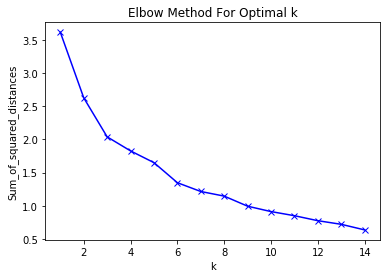

In [39]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [40]:

neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)



In [41]:
toronto_merged = subsettoronto


toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() 

,Postcode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M4E,East Toronto,The Beaches,43.676357,-79.293031,3,Trail,Pub,Health Food Store,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Women's Store
1,M4K,East Toronto,"The Danforth West,Riverdale",43.679557,-79.352188,2,Greek Restaurant,Italian Restaurant,Coffee Shop,Bookstore,Ice Cream Shop,Furniture / Home Store,Grocery Store,Frozen Yogurt Shop,Pub,Pizza Place
2,M4L,East Toronto,"The Beaches West,India Bazaar",43.668999,-79.315572,2,Sandwich Place,Liquor Store,Fast Food Restaurant,Ice Cream Shop,Intersection,Sushi Restaurant,Brewery,Food & Drink Shop,Pub,Fish & Chips Shop
3,M4M,East Toronto,Studio District,43.659526,-79.340923,2,Café,Coffee Shop,Gastropub,Bakery,Italian Restaurant,Brewery,American Restaurant,Yoga Studio,Comfort Food Restaurant,Seafood Restaurant
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,0,Park,Bus Line,Swim School,Women's Store,Dim Sum Restaurant,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop


In [42]:

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

I am not sure I know Toronto well enough to make sense of why there are outliers, while most neighborhoods fall into one cluster.

I am not sure I know Toronto well enough to make sense of why there are outliers, while most neighborhoods fall into one cluster. Evidence suggest that for most purposes, neighborhoods in Toronto are rather uniform, they have a similar selection of restraurants, shops, cafes, gyms, community organizations, etc. It does not look like some areas are particularly dominated by Asian restaurants or Italian restaurants, for example, or just pubs or diners, or that yoga studios are concentrated in some parts of the city but are unavailable in others. 